In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from scipy.special import softmax
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import pickle
import hmm_main as h

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1050 (0000:01:00.0)


In [2]:
import theano
import theano.tensor as T


In [3]:
class HMM:
    def __init__(self, M, K):
        self.M = M # количество скрытых состояний
        self.K = K # число гауссиан
    
    def fit(self, X, learning_rate=1e-2, max_iter=10, keep=False):
       
        N = len(X)
        D = X[0].shape[1] # X[0].shape = (T, D)
        
        if not keep:
            pi0 = np.ones(self.M) 
            A0 = np.random.randn(self.M, self.M) 
            R0 = np.ones((self.M, self.K)) 
            mu0 = np.zeros((self.M, self.K, D))
            for i in range(self.M):
                for k in range(self.K):
                    random_idx = np.random.choice(N)
                    x = X[random_idx]
                    random_time_idx = np.random.choice(len(x))
                    mu0[i,k] = x[random_time_idx]
            sigma0 = np.random.randn(self.M, self.K, D, D)
            thx, cost = self.set(pi0, A0, R0, mu0, sigma0)
        else:
            thx, cost = self.set(self.preSoftmaxPi.get_value(), self.preSoftmaxA.get_value(), 
                                 self.preSoftmaxR.get_value(), self.mu.get_value(), self.sigmaFactor.get_value())

        pi_update = self.preSoftmaxPi - learning_rate*T.grad(cost, self.preSoftmaxPi)
        A_update = self.preSoftmaxA - learning_rate*T.grad(cost, self.preSoftmaxA)
        R_update = self.preSoftmaxR - learning_rate*T.grad(cost, self.preSoftmaxR)
        mu_update = self.mu - learning_rate*T.grad(cost, self.mu)
        sigma_update = self.sigmaFactor - learning_rate*T.grad(cost, self.sigmaFactor)

        updates = [
            (self.preSoftmaxPi, pi_update),
            (self.preSoftmaxA, A_update),
            (self.preSoftmaxR, R_update),
            (self.mu, mu_update),
            (self.sigmaFactor, sigma_update),
        ]

        train_op = theano.function(
            inputs=[thx],
            updates=updates,
        )

        costs = []
        for it in range(max_iter):
            print("it:", it)
            c = self.log_likelihood_multi(X).sum()
            print("c:", c)
            costs.append(c)            
            
            for n in range(N):
                train_op(X[n])

        plt.plot(costs)
        plt.show()

    def set(self, preSoftmaxPi, preSoftmaxA, preSoftmaxR, mu, sigmaFactor):
        self.preSoftmaxPi = theano.shared(preSoftmaxPi)
        self.preSoftmaxA = theano.shared(preSoftmaxA)
        self.preSoftmaxR = theano.shared(preSoftmaxR)
        self.mu = theano.shared(mu)
        self.sigmaFactor = theano.shared(sigmaFactor)
        M, K = preSoftmaxR.shape
        self.M = M
        self.K = K

        pi = T.nnet.softmax(self.preSoftmaxPi).flatten()
        A = T.nnet.softmax(self.preSoftmaxA)
        R = T.nnet.softmax(self.preSoftmaxR)


        D = self.mu.shape[2]
        twopiD = (2*np.pi)**D

        # настройка переменных и функций theano 
        thx = T.matrix('X') # матрица TxD последовательных наблюдений
        def mvn_pdf(x, m, S):
            k = 1 / T.sqrt(twopiD * T.nlinalg.det(S))
            e = T.exp(-0.5*(x - m).T.dot(T.nlinalg.matrix_inverse(S).dot(x - m)))
            return k*e

        def gmm_pdf(x):
            def state_pdfs(xt):
                def component_pdf(j, xt):
                    Bj_t = 0
                    for k in range(self.K):
                        L = self.sigmaFactor[j,k]
                        S = L.dot(L.T)
                        Bj_t += R[j,k] * mvn_pdf(xt, self.mu[j,k], S)
                    return Bj_t

                Bt, _ = theano.scan(
                    fn=component_pdf,
                    sequences=T.arange(self.M),
                    n_steps=self.M,
                    outputs_info=None,
                    non_sequences=[xt],
                )
                return Bt

            B, _ = theano.scan(
                fn=state_pdfs,
                sequences=x,
                n_steps=x.shape[0],
                outputs_info=None,
            )
            return B.T
        
        B = gmm_pdf(thx)
       
        def recurrence(t, old_a, B):
            a = old_a.dot(A) * B[:, t]
            s = a.sum()
            return (a / s), s

        [alpha, scale], _ = theano.scan(
            fn=recurrence,
            sequences=T.arange(1, thx.shape[0]),
            outputs_info=[pi*B[:,0], None],
            n_steps=thx.shape[0]-1,
            non_sequences=[B],
        )

        cost = -T.log(scale).sum()
        self.cost_op = theano.function(
            inputs=[thx],
            outputs=cost,
        )
        
        cost_detect = -T.log(scale)
        self.cost_detect = theano.function(
            inputs=[thx],
            outputs=cost_detect,
        )
        return thx, cost

    def log_likelihood_multi(self, X):
        return np.array([self.cost_op(x) for x in X])
    
    def log_likelihood_detect(self, X):
        return np.array(self.cost_detect(X))    

In [4]:
def anom3_init(N,T):
    X = []
    for n in range(N):
        s = (10*np.random.randn(T) + 2*np.sin(np.linspace(0, 20*np.pi, T)))
        X.append(s.reshape(T,1))
    return X

def anom2_init(model= None):
    M = 1
    K = 1
    D = 1
    pi = np.array([1])
    A = np.array([[1]])
    R = np.array([[1]])
    mu = np.array([[[20]]])
    sigma = np.array([[[[0.0001]]]])
    return M, K, D, pi, A, R, mu, sigma

def anom1_init(model= None):
    M = 1
    K = 1
    D = 1
    pi = np.array([1])
    A = np.array([[1]])
    R = np.array([[1]])
    mu = np.array([[[10]]])
    sigma = np.array([[[[10]]]])
    return M, K, D, pi, A, R, mu, sigma

def anom0_init(model= None):
    M = 1
    K = 1
    D = 1
    pi = np.array([1])
    A = np.array([[1]])
    R = np.array([[1]])
    mu = np.array([[[-5]]])
    sigma = np.array([[[[1]]]])
    return M, K, D, pi, A, R, mu, sigma

def big_init(model= None):
    M = 5
    K = 3
    D = 1

    pi = np.array([1, 0, 0, 0, 0]) # initial state distribution

    A = np.array([
        [0.9, 0.025, 0.025, 0.025, 0.025],
        [0.025, 0.9, 0.025, 0.025, 0.025],
        [0.025, 0.025, 0.9, 0.025, 0.025],
        [0.025, 0.025, 0.025, 0.9, 0.025],
        [0.025, 0.025, 0.025, 0.025, 0.9],
    ]) # state transition matrix - likes to stay where it is

    R = np.ones((M, K)) / K # mixture proportions

    mu = np.array([
        [[0], [1], [2]],
        [[5], [6], [7]],
        [[10], [11], [12]],
        [[15], [16], [17]],
        [[20], [21], [22]],
    ]) # M x K x D

    sigma = np.zeros((M, K, D, D))
    for m in range(M):
        for k in range(K):
            sigma[m,k] = np.eye(D)
    return M, K, D, pi, A, R, mu, sigma

def hmm_init(model):
    
    mu = model.mu.get_value()
    sigmaFactor = model.sigmaFactor.get_value()
    
    pi = softmax(model.preSoftmaxPi.get_value())
    A = softmax(model.preSoftmaxA.get_value(), axis=1)
    R = softmax(model.preSoftmaxR.get_value(), axis=1)
    D = mu.shape[2]
    M, K = R.shape
    
    return M, K, D, pi, A, R, mu, sigmaFactor
    
def get_signals(N=20, T=100, init=big_init, hmm_model = None):
    if init == anom3_init:
        X = init(N,T)
    else:
        M, K, D, pi, A, R, mu, sigma = init(hmm_model)
        X = []
    
        def get_sigma_s_r(hmm_model, s, r, sigma):
            if hmm_model != None:
                L = sigma[s][r]
                return L.dot(L.T)
            else:
                return sigma[s,r]

        for n in range(N):
            x = np.zeros((T, D))
            s = np.random.choice(M, p = pi) # выбираем начальное состояние
            r = np.random.choice(K, p=R[s]) # choose mixture
            x[0] = np.random.multivariate_normal(mu[s][r], get_sigma_s_r(hmm_model, s, r, sigma))
            for t in range(1, T):
                s = np.random.choice(M, p=A[s]) # choose state
                r = np.random.choice(K, p=R[s]) # choose mixture
                x[t] = np.random.multivariate_normal(mu[s][r], get_sigma_s_r(hmm_model, s, r, sigma))
            X.append(x)
    return X

In [5]:
# ЧТЕНИЕ
with open('C:/Users/DNS/NIR/hmm_big_init.pkl', 'rb') as dump_out:
      hmm = pickle.load(dump_out)

with open('C:/Users/DNS/NIR/X_train.pkl', 'rb') as dump_out:
      X_train = pickle.load(dump_out)        

In [ ]:
_, _, _, pi, A, R, mu, sigma = big_init()
# перевод в формы "pre-softmax" 
pi = np.log(pi)
A = np.log(A)
R = np.log(R)
# декомпозиция sigma с использованием факторизации 
sigma = np.linalg.cholesky(sigma)

hmm_real = HMM(5, 3)
hmm_real.set(pi, A, R, mu, sigma)

In [ ]:
LL_learning = hmm.log_likelihood_multi(X_train)
LL_original = hmm_real.log_likelihood_multi(X_train)


In [15]:
MAPE_hmm = sum([abs(LL_learning[i]-LL_original[i])/LL_original[i] for i in range(len(X_train))])/len(X_train)
MAPE_hmm

0.09603704549805477

In [6]:
def mix_examples(N=10, T = 100, len_past = 10, anom_init = anom0_init, gap=20):
    signals = get_signals(N, T, init = big_init)
    anomalises = get_signals(N, len_past, init = anom_init)
    idx = np.random.choice(T-len_past-1, size = N, replace = False)
    label = np.zeros((N,T))
    for i in range(N):
        idx_an = min(idx[i], idx[i]-gap)
        #print(idx[i], idx_an)
        signals[i][idx[i]:idx[i]+len_past,0] = anomalises[i][:,0]
        label[i][idx_an:idx[i]+len_past]+=1
    return signals, label
    

In [7]:
def get_example(T = 100, k = 0.1, rate = 0.3, name_an = None ):
    
    if name_an== None:
        name_an = [anom0_init, anom1_init, anom3_init]
    
    l = int(T*(1-rate)//2)
    max_len = int(k*T)
    
    label = np.zeros((T))
    X = np.empty(shape=[0, 1])
    while X.shape[0] < T:
        
        limit = min(l ,T-X.shape[0])
        if limit > 10:
            X = np.concatenate([X, get_signals(1, np.random.randint(10,limit), init = big_init)[0]])
        
        init = np.random.choice(name_an)
        if init in [anom1_init, anom2_init]:
            min_len = 20
        else:
            min_len = 5
            
        limit = min(T-X.shape[0],max_len)
        
        if limit > min_len:
            len_past = np.random.randint(5,limit)
            X = np.concatenate([X, get_signals(1, len_past, init = np.random.choice(name_an))[0]])
            label[min(X.shape[0],T)-len_past: min(X.shape[0],T)] = 1
        else:
            X = np.concatenate([X, get_signals(1, limit, init = big_init)[0]])
               
        if X.shape[0] > T:
            X = np.delete(X, range(T,t), axis = 0)
            
                                 
    return X, label

def get_test_set(N=10, T=100, k=0.1, rate=0.3, name_an = None):
    X = []
    Y = []
    for n in range(N):
        x,y = get_example(T, k, rate, name_an)
        X.append(x)
        Y.append(y)
    return X, Y
    

In [12]:

def anomaly_detection(LL_std, hmm_model, signal, win_size= 100, eps = 0.25, step = 1):
    n_step = signal.shape[0]
    LL = hmm_model.log_likelihood_detect(signal)
    an = np.zeros(n_step)
    Y = np.zeros(n_step)
    t=0
    for t in range(0,(n_step-win_size+step) , step):
    #while t < (n_step-win_size+step):
        if t > (n_step-win_size):
            t = n_step-win_size
        MAPE = abs(LL[t:t+win_size].sum()-LL_std)/LL_std
        if MAPE > eps :
            if t==0 or t+win_size == n_step:
                Y[t:t+win_size] =1
            else:
                Y[t+win_size-step:t+win_size] =1
            #Y[t:t+win_size] =1
            #t += win_size
        #else:
           # t += step 
            #LL[t] = LL_hmm[t]
    #Y[np.where(an>an.max()*sens)] = 1          
    return Y 

def predict(model, X, Y, win_size=50, eps=0.25, step =1):
    Y_pred = []
    hmm_signal = get_signals(100, win_size ,init=hmm_init, hmm_model = model)
    LL_std = np.array([model.log_likelihood_detect(x) for x in hmm_signal]).sum()/100
    for x in X:
        Y_pred.append(anomaly_detection(LL_std, model, x, win_size, eps, step))
        
    return Y_pred

def score(Y, Y_pred, ws = 50): 
    
    T = Y[0].shape[0]
    assert (T%ws==0), "неверный размер окна"
    Y_new = []
    Y_pred_new = []
    
    for i in range(len(Y)):
        a = Y[i].reshape(T//ws, ws)
        b = Y_pred[i].reshape(T//ws, ws)
        
        y_new = np.zeros((T//ws))
        y_pred_new = np.zeros((T//ws))
        
        for j in range(a.shape[0]):
            if np.where(a[j]==1)[0].shape[0] != 0:
                y_new[j] = 1
            if np.where(b[j]==1)[0].shape[0] != 0:
                y_pred_new[j] = 1
                
        Y_new.append(y_new)
        Y_pred_new.append(y_pred_new)
        
    return Y_new, Y_pred_new           
            

In [15]:
def print_result(X, Y, Y_pred, N=3):
    for n in range(N):
        norm = np.ma.masked_where(Y_pred[n]==0,X[n][:,0])
        anom = np.ma.masked_where(Y_pred[n]==1,X[n][:,0])
        fig = plt.figure(figsize=(18, 4))
        axis = range(Y_pred[n].shape[0])
        idxs = np.where(Y[n] == Y[n].max())[0]
        for i in idxs:
            plt.axvspan(i, i, color='yellow')
        plt.plot(axis, norm, axis, anom, axis, Y_pred[n]*25)
        plt.show()       
    

In [22]:
def testing(X, Y, model, N=5, ws_s = [20, 45, 60, 80, 100, 120], eps_s = [0.15, 0.20, 0.25, 0.3, 0.35, 0.4]):
    
    for n in range(N):
        plt.figure(figsize=(18, 4))
        plt.plot(X[n])
        idxs = np.where(Y[n] == Y[n].max())[0]
        for i in range(len(idxs)):
            plt.axvspan(idxs[i], idxs[i], color='yellow')
        plt.show()
    
    result_testing = []
    #ws_s = [20, 45, 60, 80, 100, 120, 150, 200]
    #eps_s = [0.15, 0.20, 0.25, 0.3, 0.35, 0.4]
    step_s = [10, 20, 20, 20, 20, 20]
    
    for i in range(len(ws_s)):
        ws = ws_s[i]
        step = step_s[i]
        res_eps = []
        for eps in eps_s:
            Y_pred = predict(model, X, Y, win_size= ws, eps = eps, step =step)
            Y_score, Y_pred_score = score(Y, Y_pred, ws = 50)
            res_eps.append(classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'], output_dict=True))
        result_testing.append(res_eps)
    return result_testing       

ПЕРВЫЙ ТИП АНОМАЛИЙ!!!!!!!!!

In [9]:
X_anom0, Y_anom0 = get_test_set(N=5, T=500, name_an = [anom0_init, anom0_init])

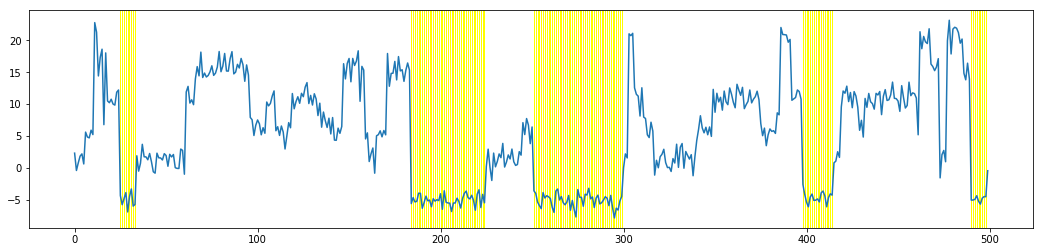

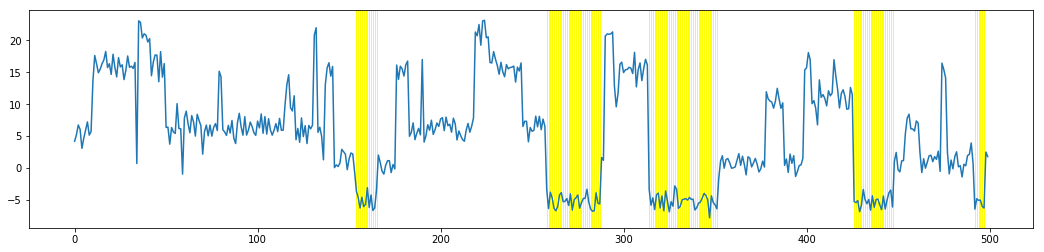

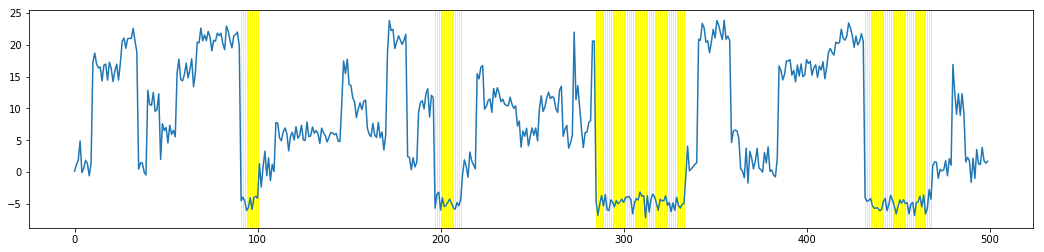

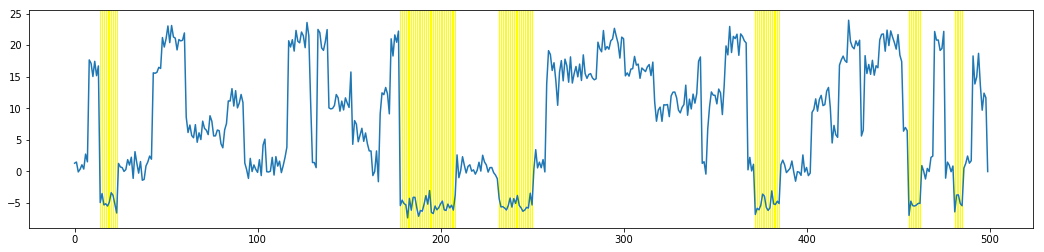

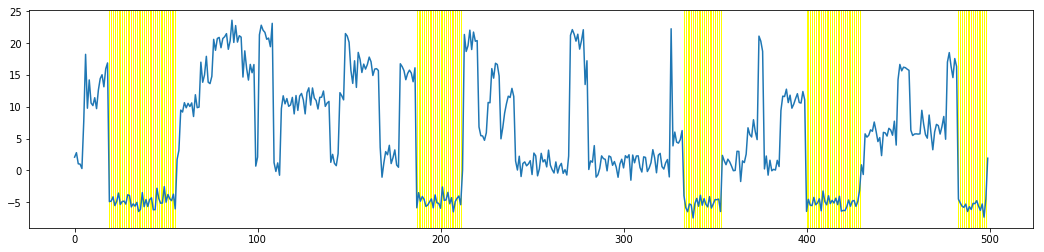

In [38]:
#eps_s = [45]
result_anom0 = testing(X_anom0, Y_anom0, hmm, N=5)#, ws_s = ws_s)

In [39]:
ws_s = [20, 45, 60, 80, 100, 120]
eps_s = [0.15, 0.20, 0.25, 0.3, 0.35, 0.4]
step_s = [10, 20, 20, 20, 20, 20]
len(result_anom0)
for i in range(6):
    print('ws',ws_s[i])
    for j in range(6):
        print('eps',eps_s[j], result_anom0[i][j]['anomal'])
        

ws 20
eps 0.15 {'precision': 0.7291666666666666, 'recall': 1.0, 'f1-score': 0.8433734939759037, 'support': 35}
eps 0.2 {'precision': 0.813953488372093, 'recall': 1.0, 'f1-score': 0.8974358974358974, 'support': 35}
eps 0.25 {'precision': 0.8536585365853658, 'recall': 1.0, 'f1-score': 0.9210526315789475, 'support': 35}
eps 0.3 {'precision': 0.9722222222222222, 'recall': 1.0, 'f1-score': 0.9859154929577464, 'support': 35}
eps 0.35 {'precision': 0.9722222222222222, 'recall': 1.0, 'f1-score': 0.9859154929577464, 'support': 35}
eps 0.4 {'precision': 0.9714285714285714, 'recall': 0.9714285714285714, 'f1-score': 0.9714285714285714, 'support': 35}
ws 45
eps 0.15 {'precision': 0.7954545454545454, 'recall': 1.0, 'f1-score': 0.8860759493670886, 'support': 35}
eps 0.2 {'precision': 0.8536585365853658, 'recall': 1.0, 'f1-score': 0.9210526315789475, 'support': 35}
eps 0.25 {'precision': 0.8536585365853658, 'recall': 1.0, 'f1-score': 0.9210526315789475, 'support': 35}
eps 0.3 {'precision': 0.853658536

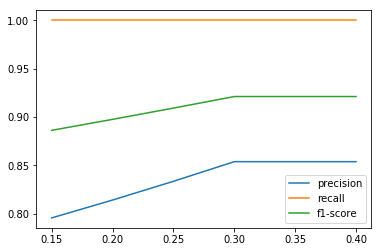

In [37]:
fig, ax = plt.subplots()
axis = eps_s
ax.plot(axis, [x['anomal']['precision'] for x in result_anom0[1]], label = 'precision') 
ax.plot(axis, [x['anomal']['recall'] for x in result_anom0[1]], label = 'recall') 
ax.plot(axis, [x['anomal']['f1-score'] for x in result_anom0[1]], label = 'f1-score')
ax.legend()
plt.show()       

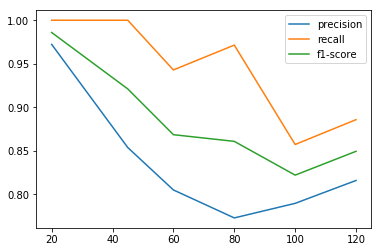

In [40]:
fig, ax = plt.subplots()
axis = ws_s
ax.plot(axis, [x[4]['anomal']['precision'] for x in result_anom0], label = 'precision') 
ax.plot(axis, [x[4]['anomal']['recall'] for x in result_anom0], label = 'recall') 
ax.plot(axis, [x[4]['anomal']['f1-score'] for x in result_anom0], label = 'f1-score')
ax.legend()
plt.show()  

In [43]:
X_anom0, Y_anom0 = get_test_set(N=10, T=1000, name_an = [anom0_init, anom0_init])
Y_pred = predict(hmm, X_anom0, Y_anom0, win_size= 45, eps = 0.25, step = 20)


              precision    recall  f1-score   support

      normal       1.00      0.77      0.87       120
      anomal       0.74      1.00      0.85        80

    accuracy                           0.86       200
   macro avg       0.87      0.88      0.86       200
weighted avg       0.90      0.86      0.86       200



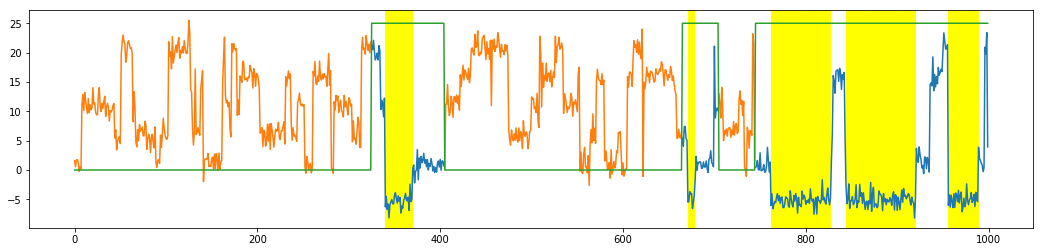

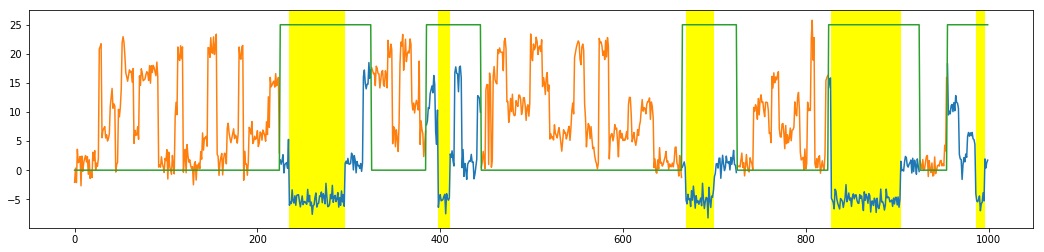

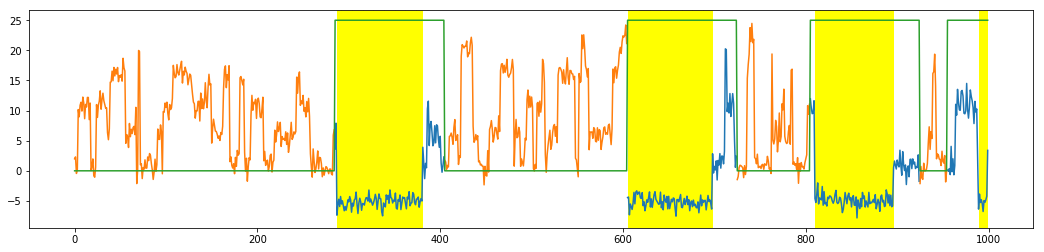

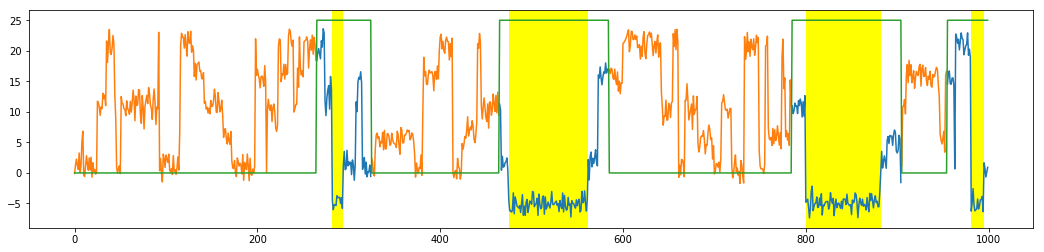

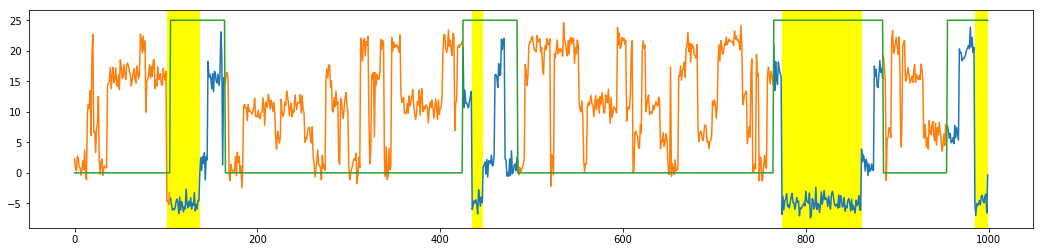

In [45]:
Y_score, Y_pred_score = score(Y_anom0, Y_pred, ws = 50)
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)
print_result(X_anom0, Y_anom0, Y_pred, N=5)

ВТОРОЙ ТИП АНОМАЛИЙ!!!!!!!!!

In [47]:
X_anom1, Y_anom1 = get_test_set(N=5, T=500, name_an = [anom1_init, anom1_init])

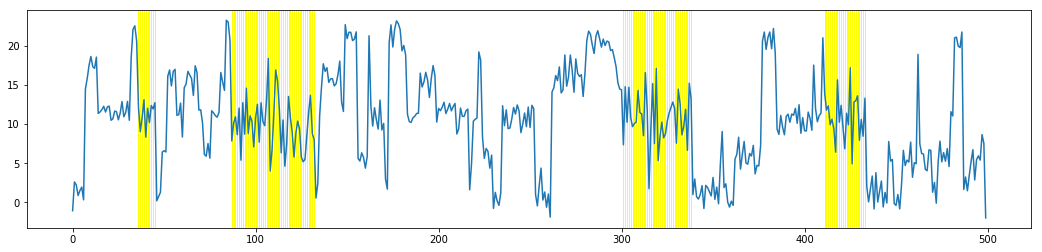

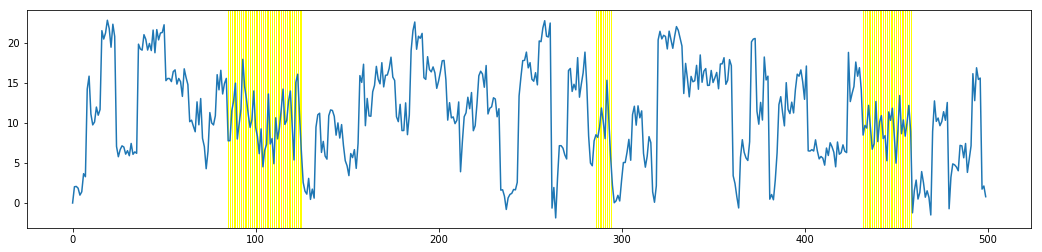

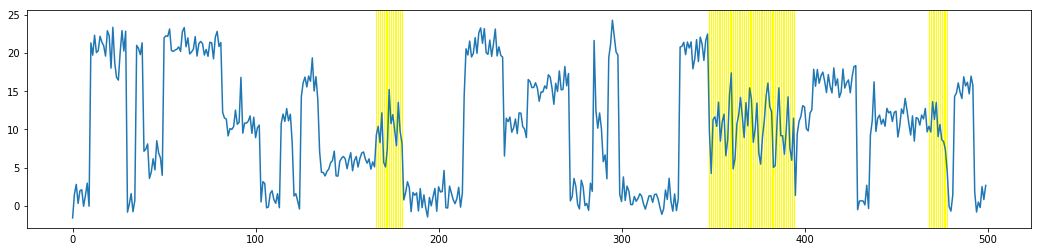

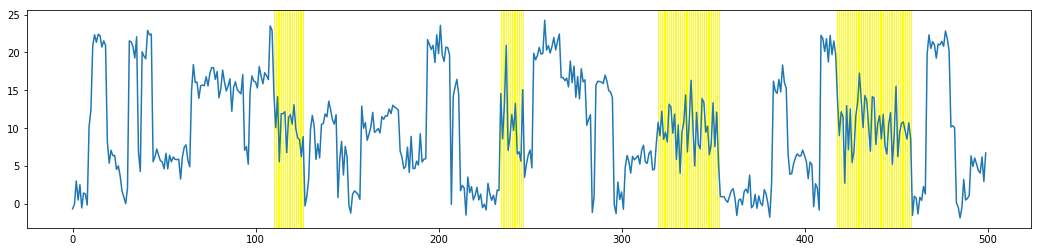

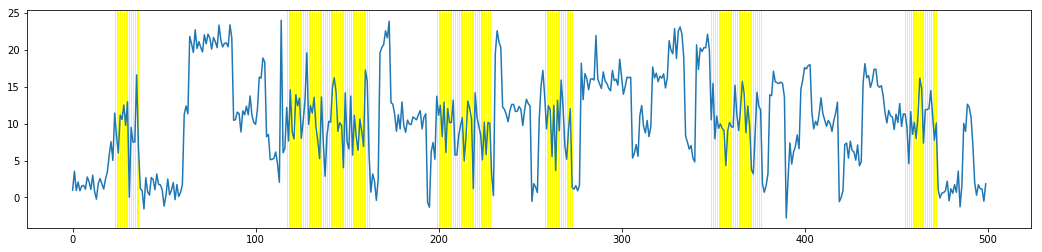

In [48]:
result_anom1 = testing(X_anom1, Y_anom1, hmm, N=5)#, ws_s = ws_s)

ws 20
eps 0.15 {'precision': 0.6136363636363636, 'recall': 0.9642857142857143, 'f1-score': 0.75, 'support': 28}
eps 0.2 {'precision': 0.7058823529411765, 'recall': 0.8571428571428571, 'f1-score': 0.7741935483870968, 'support': 28}
eps 0.25 {'precision': 0.8333333333333334, 'recall': 0.7142857142857143, 'f1-score': 0.7692307692307692, 'support': 28}
eps 0.3 {'precision': 0.9375, 'recall': 0.5357142857142857, 'f1-score': 0.6818181818181818, 'support': 28}
eps 0.35 {'precision': 1.0, 'recall': 0.39285714285714285, 'f1-score': 0.5641025641025641, 'support': 28}
eps 0.4 {'precision': 1.0, 'recall': 0.35714285714285715, 'f1-score': 0.5263157894736842, 'support': 28}
ws 45
eps 0.15 {'precision': 0.6470588235294118, 'recall': 0.7857142857142857, 'f1-score': 0.7096774193548386, 'support': 28}
eps 0.2 {'precision': 0.8095238095238095, 'recall': 0.6071428571428571, 'f1-score': 0.6938775510204083, 'support': 28}
eps 0.25 {'precision': 0.8888888888888888, 'recall': 0.5714285714285714, 'f1-score': 0

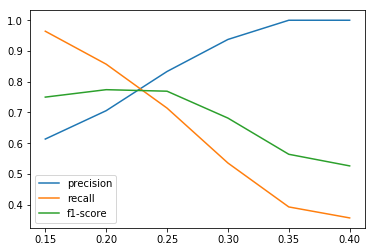

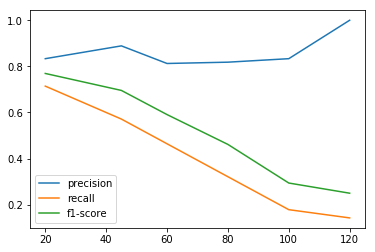

In [50]:
ws_s = [20, 45, 60, 80, 100, 120]
eps_s = [0.15, 0.20, 0.25, 0.3, 0.35, 0.4]
step_s = [10, 20, 20, 20, 20, 20]

for i in range(6):
    print('ws',ws_s[i])
    for j in range(6):
        print('eps',eps_s[j], result_anom1[i][j]['anomal'])
        
fig, ax = plt.subplots()
axis = eps_s
ax.plot(axis, [x['anomal']['precision'] for x in result_anom1[0]], label = 'precision') 
ax.plot(axis, [x['anomal']['recall'] for x in result_anom1[0]], label = 'recall') 
ax.plot(axis, [x['anomal']['f1-score'] for x in result_anom1[0]], label = 'f1-score')
ax.legend()
plt.show() 

fig, ax = plt.subplots()
axis = ws_s
ax.plot(axis, [x[2]['anomal']['precision'] for x in result_anom1], label = 'precision') 
ax.plot(axis, [x[2]['anomal']['recall'] for x in result_anom1], label = 'recall') 
ax.plot(axis, [x[2]['anomal']['f1-score'] for x in result_anom1], label = 'f1-score')
ax.legend()
plt.show()        

              precision    recall  f1-score   support

      normal       0.86      0.94      0.90       126
      anomal       0.89      0.74      0.81        74

    accuracy                           0.87       200
   macro avg       0.87      0.84      0.86       200
weighted avg       0.87      0.87      0.87       200



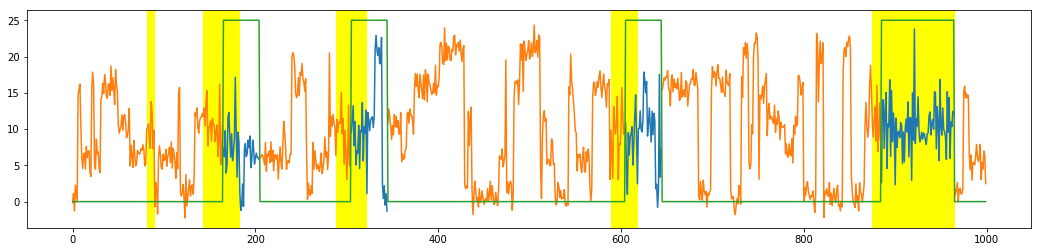

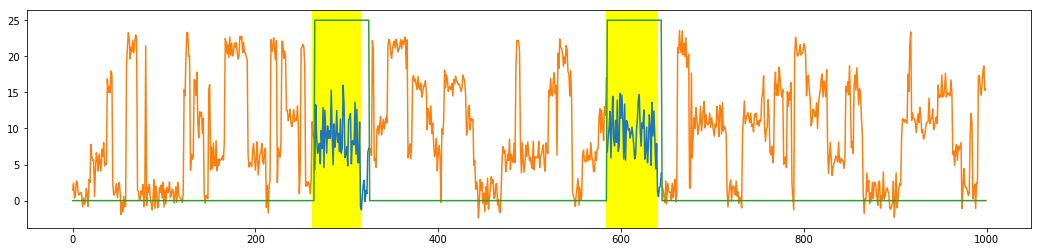

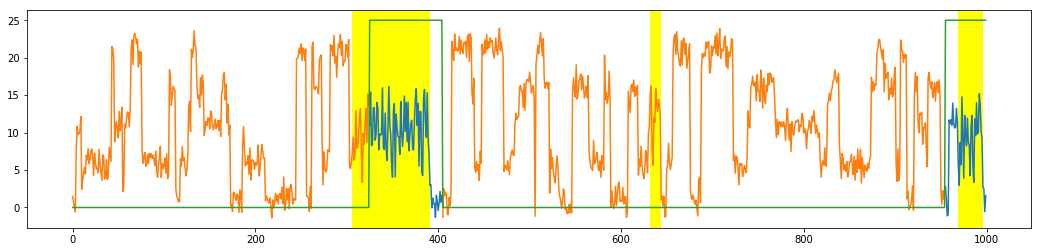

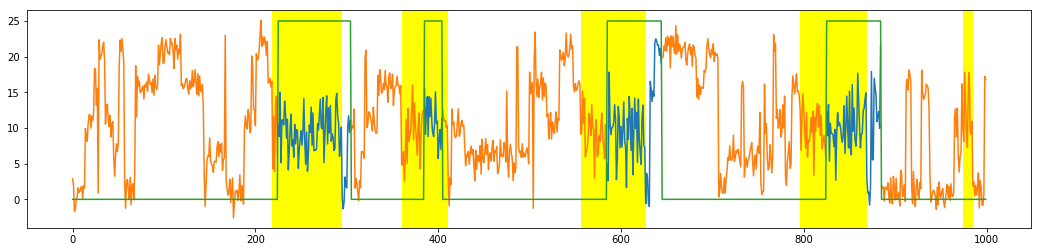

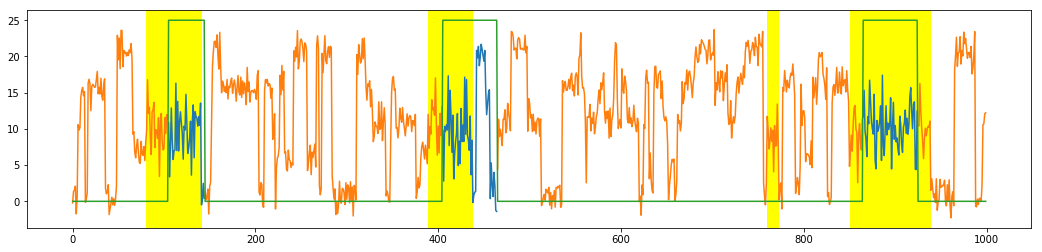

In [55]:
X_anom1, Y_anom1 = get_test_set(N=10, T=1000, name_an = [anom1_init, anom1_init])
Y_pred = predict(hmm, X_anom1, Y_anom1, win_size= 45, eps = 0.25, step = 20)
Y_score, Y_pred_score = score(Y_anom1, Y_pred, ws = 50)
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)
print_result(X_anom1, Y_anom1, Y_pred, N=5)

ТРЕТИЙ ТИП АНОМАЛИЙ!!!!!!!!!

In [56]:
X_anom2, Y_anom2 = get_test_set(N=5, T=500, name_an = [anom2_init, anom2_init])

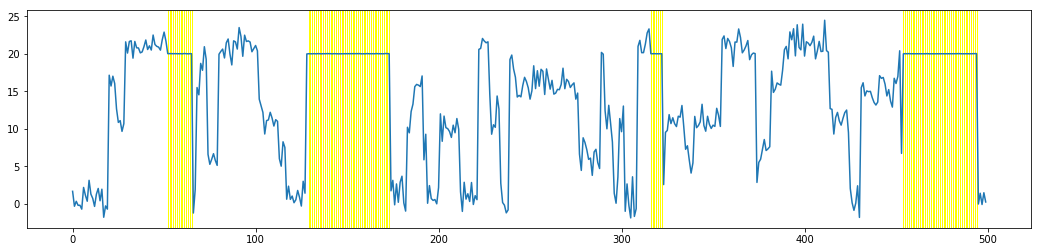

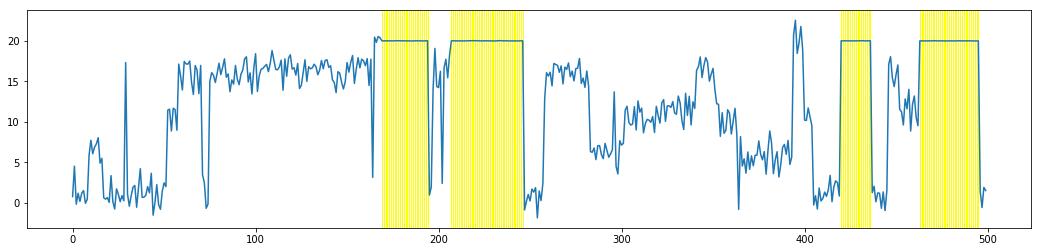

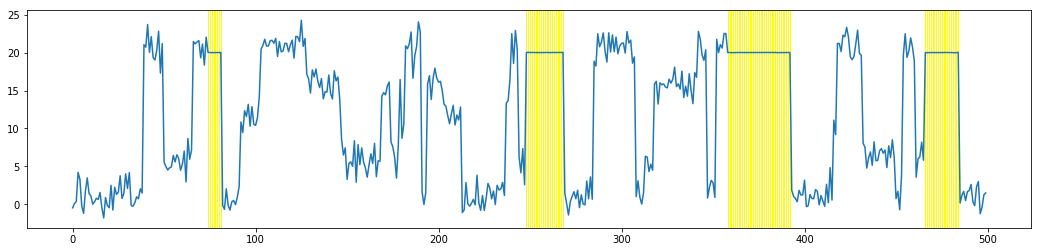

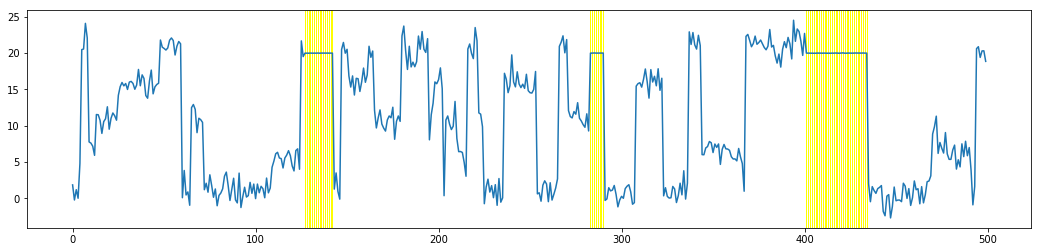

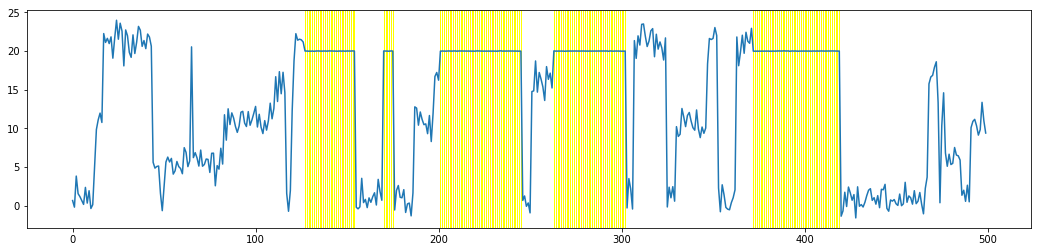

In [57]:
result_anom2 = testing(X_anom2, Y_anom2, hmm, N=5)

ws 20
eps 0.15 {'precision': 0.5581395348837209, 'recall': 1.0, 'f1-score': 0.7164179104477612, 'support': 24}
eps 0.2 {'precision': 0.5757575757575758, 'recall': 0.7916666666666666, 'f1-score': 0.6666666666666667, 'support': 24}
eps 0.25 {'precision': 0.6071428571428571, 'recall': 0.7083333333333334, 'f1-score': 0.6538461538461539, 'support': 24}
eps 0.3 {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 24}
eps 0.35 {'precision': 0.875, 'recall': 0.5833333333333334, 'f1-score': 0.7000000000000001, 'support': 24}
eps 0.4 {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24}
ws 45
eps 0.15 {'precision': 0.5862068965517241, 'recall': 0.7083333333333334, 'f1-score': 0.6415094339622641, 'support': 24}
eps 0.2 {'precision': 0.8, 'recall': 0.6666666666666666, 'f1-score': 0.7272727272727272, 'support': 24}
eps 0.25 {'precision': 0.7777777777777778, 'recall': 0.2916666666666667, 'f1-score': 0.42424242424242425, 'support': 24}
eps 0.3 {'prec

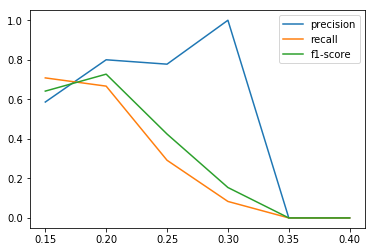

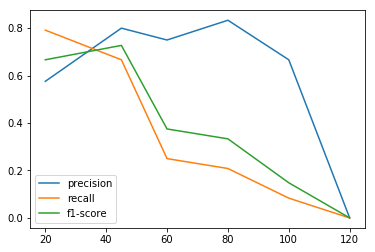

In [59]:
ws_s = [20, 45, 60, 80, 100, 120]
eps_s = [0.15, 0.20, 0.25, 0.3, 0.35, 0.4]
step_s = [10, 20, 20, 20, 20, 20]

for i in range(6):
    print('ws',ws_s[i])
    for j in range(6):
        print('eps',eps_s[j], result_anom2[i][j]['anomal'])
        
fig, ax = plt.subplots()
axis = eps_s
ax.plot(axis, [x['anomal']['precision'] for x in result_anom2[1]], label = 'precision') 
ax.plot(axis, [x['anomal']['recall'] for x in result_anom2[1]], label = 'recall') 
ax.plot(axis, [x['anomal']['f1-score'] for x in result_anom2[1]], label = 'f1-score')
ax.legend()
plt.show() 

fig, ax = plt.subplots()
axis = ws_s
ax.plot(axis, [x[1]['anomal']['precision'] for x in result_anom2], label = 'precision') 
ax.plot(axis, [x[1]['anomal']['recall'] for x in result_anom2], label = 'recall') 
ax.plot(axis, [x[1]['anomal']['f1-score'] for x in result_anom2], label = 'f1-score')
ax.legend()
plt.show()        

              precision    recall  f1-score   support

      normal       0.71      0.93      0.81        97
      anomal       0.91      0.65      0.76       103

    accuracy                           0.79       200
   macro avg       0.81      0.79      0.78       200
weighted avg       0.81      0.79      0.78       200



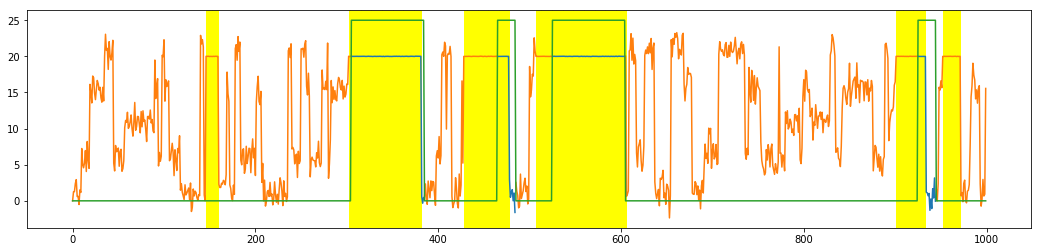

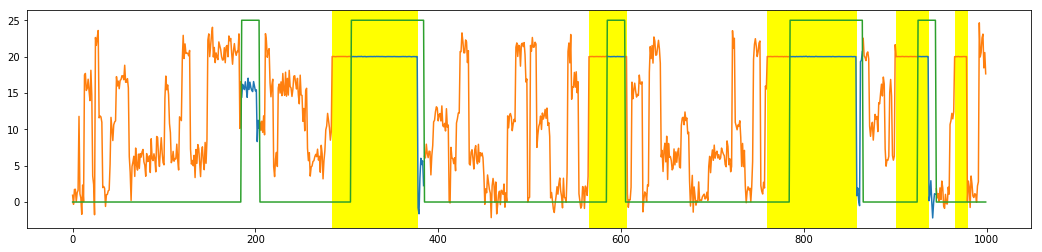

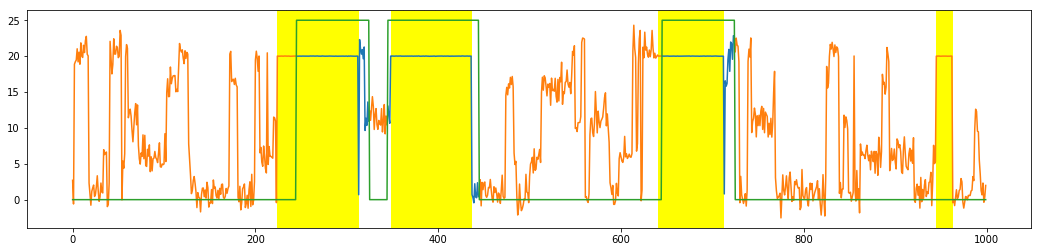

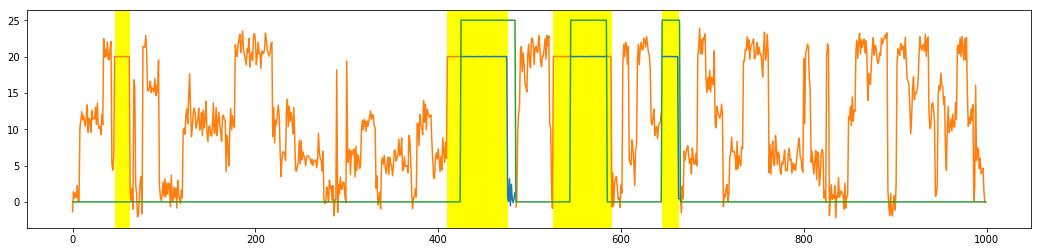

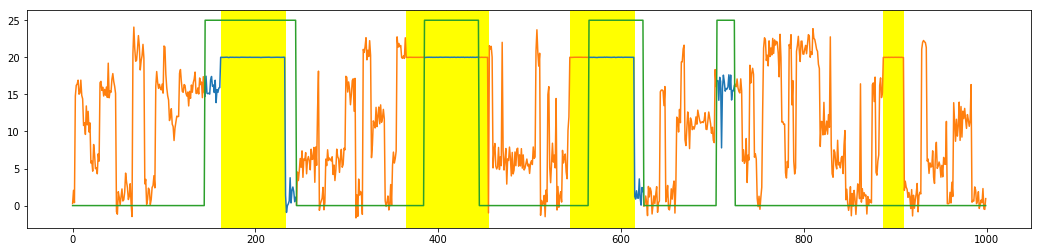

In [60]:
X_anom2, Y_anom2 = get_test_set(N=10, T=1000, name_an = [anom2_init, anom2_init])
Y_pred = predict(hmm, X_anom2, Y_anom2, win_size= 45, eps = 0.2, step = 20)
Y_score, Y_pred_score = score(Y_anom2, Y_pred, ws = 50)
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)
print_result(X_anom2, Y_anom2, Y_pred, N=5)

ЧЕТВЕРТЫЙ ТИП АНОМАЛИЙ!!!!!!!!!

In [61]:
X_anom3, Y_anom3 = get_test_set(N=5, T=500, name_an = [anom3_init, anom3_init])

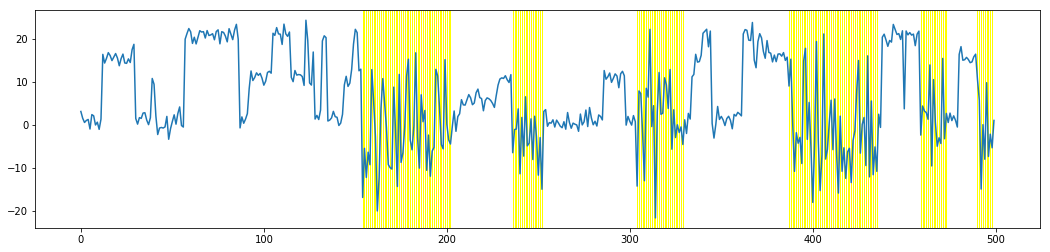

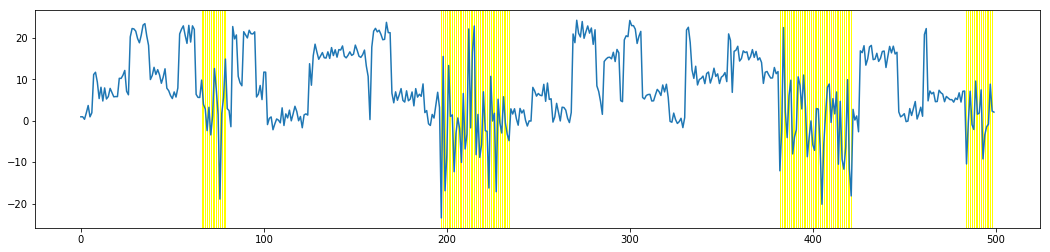

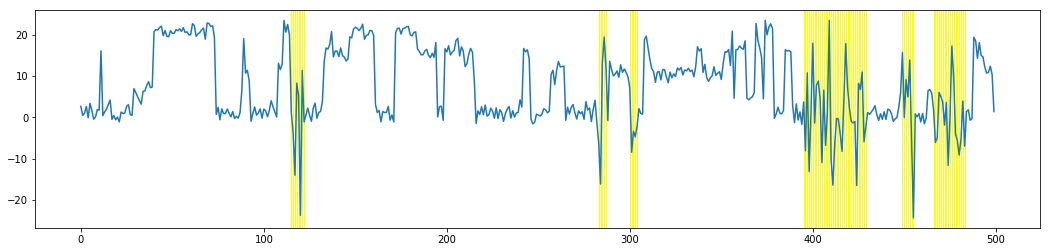

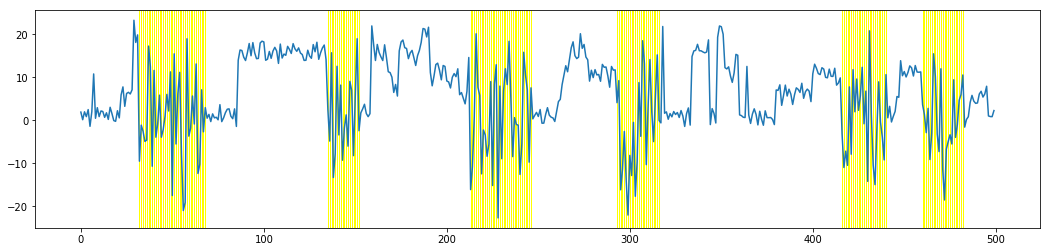

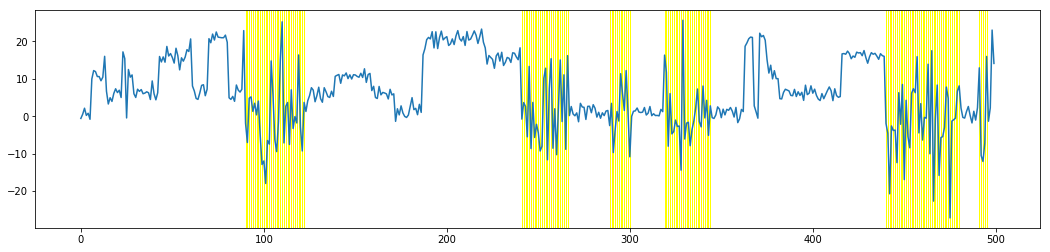

In [62]:
result_anom3 = testing(X_anom3, Y_anom3, hmm, N=5)

ws 20
eps 0.15 {'precision': 0.7954545454545454, 'recall': 1.0, 'f1-score': 0.8860759493670886, 'support': 35}
eps 0.2 {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 35}
eps 0.25 {'precision': 0.8536585365853658, 'recall': 1.0, 'f1-score': 0.9210526315789475, 'support': 35}
eps 0.3 {'precision': 0.9210526315789473, 'recall': 1.0, 'f1-score': 0.958904109589041, 'support': 35}
eps 0.35 {'precision': 0.9459459459459459, 'recall': 1.0, 'f1-score': 0.9722222222222222, 'support': 35}
eps 0.4 {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35}
ws 45
eps 0.15 {'precision': 0.8536585365853658, 'recall': 1.0, 'f1-score': 0.9210526315789475, 'support': 35}
eps 0.2 {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 35}
eps 0.25 {'precision': 0.8974358974358975, 'recall': 1.0, 'f1-score': 0.945945945945946, 'support': 35}
eps 0.3 {'precision': 0.8974358974358975, 'recall': 1.0, 'f1-score': 0.945945945945946, 'sup

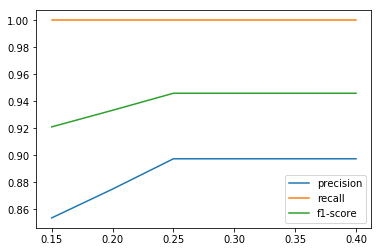

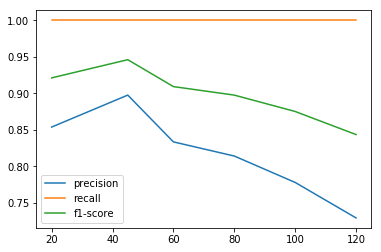

In [64]:
ws_s = [20, 45, 60, 80, 100, 120]
eps_s = [0.15, 0.20, 0.25, 0.3, 0.35, 0.4]
step_s = [10, 20, 20, 20, 20, 20]

for i in range(6):
    print('ws',ws_s[i])
    for j in range(6):
        print('eps',eps_s[j], result_anom3[i][j]['anomal'])
        
fig, ax = plt.subplots()
axis = eps_s
ax.plot(axis, [x['anomal']['precision'] for x in result_anom3[1]], label = 'precision') 
ax.plot(axis, [x['anomal']['recall'] for x in result_anom3[1]], label = 'recall') 
ax.plot(axis, [x['anomal']['f1-score'] for x in result_anom3[1]], label = 'f1-score')
ax.legend()
plt.show() 

fig, ax = plt.subplots()
axis = ws_s
ax.plot(axis, [x[2]['anomal']['precision'] for x in result_anom3], label = 'precision') 
ax.plot(axis, [x[2]['anomal']['recall'] for x in result_anom3], label = 'recall') 
ax.plot(axis, [x[2]['anomal']['f1-score'] for x in result_anom3], label = 'f1-score')
ax.legend()
plt.show()        

              precision    recall  f1-score   support

      normal       0.99      0.75      0.85       108
      anomal       0.77      0.99      0.87        92

    accuracy                           0.86       200
   macro avg       0.88      0.87      0.86       200
weighted avg       0.89      0.86      0.86       200



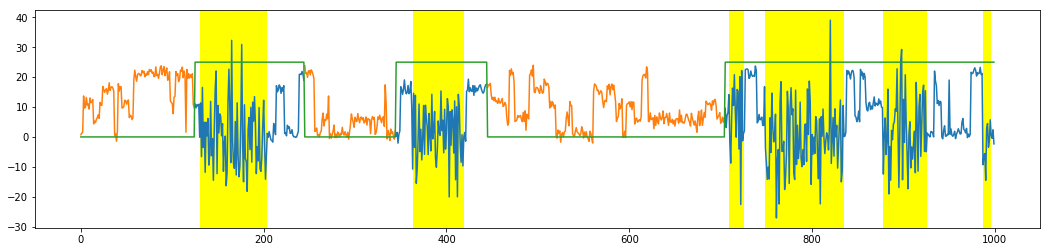

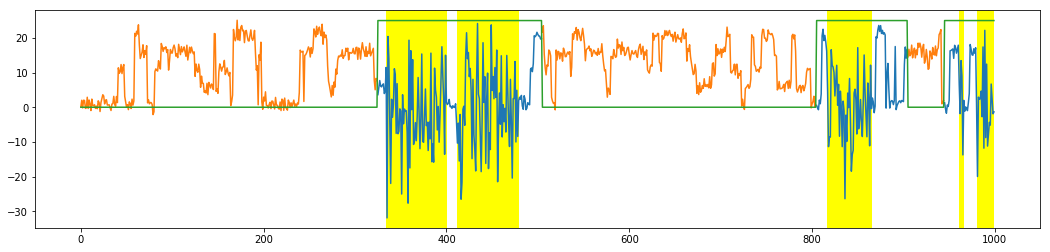

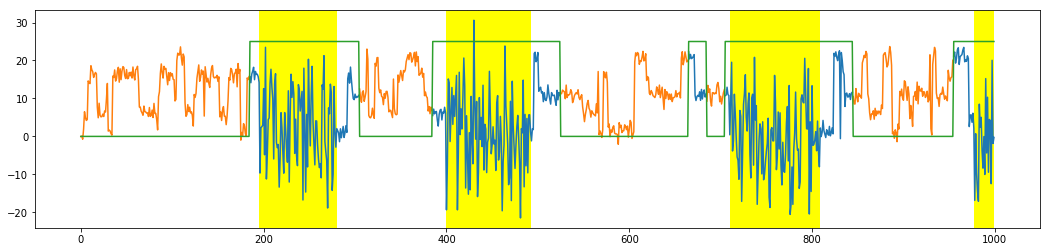

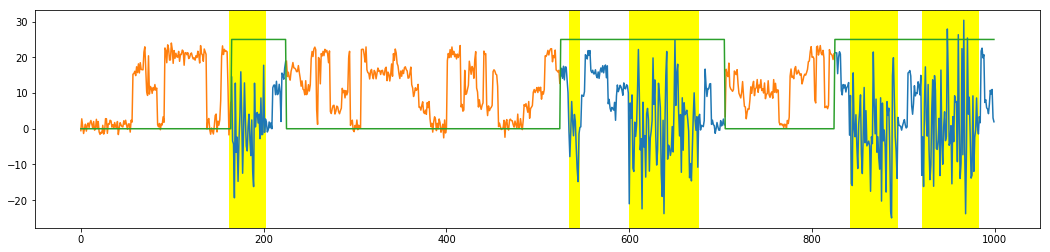

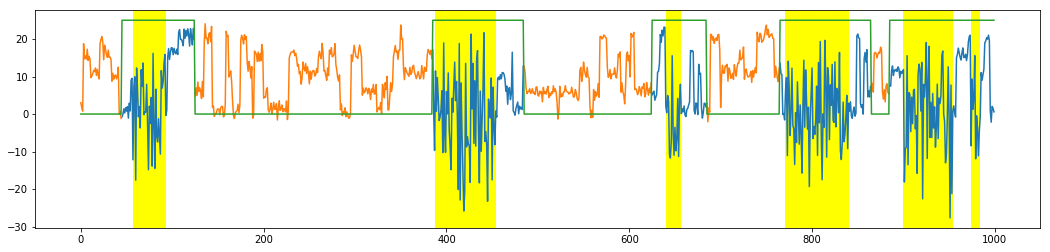

In [65]:
X_anom3, Y_anom3 = get_test_set(N=10, T=1000, name_an = [anom3_init, anom3_init])
Y_pred = predict(hmm, X_anom3, Y_anom3, win_size= 45, eps = 0.25, step = 20)
Y_score, Y_pred_score = score(Y_anom3, Y_pred, ws = 50)
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)
print_result(X_anom3, Y_anom3, Y_pred, N=5)

ИТОГОВОЕ ТЕСТИРОВАНИЕ!!!!!!!!!

In [72]:
with open('C:/Users/DNS/NIR/X_Y_test.pkl', 'rb') as dump_out:
      X_test, Y_test = pickle.load(dump_out) 

In [76]:
X_test = [x.reshape(1000,1) for x in X_test]

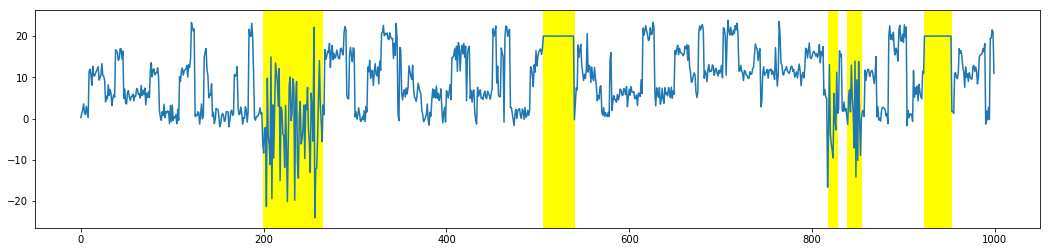

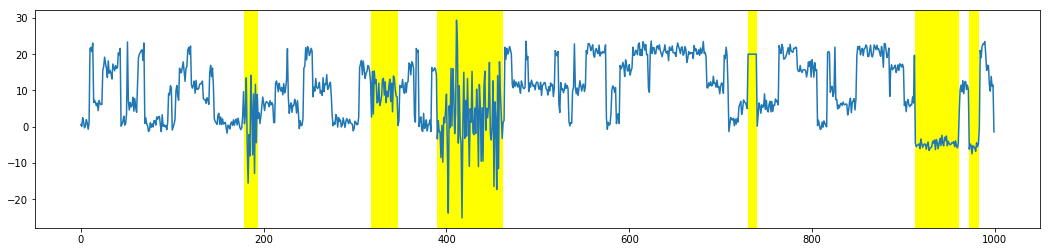

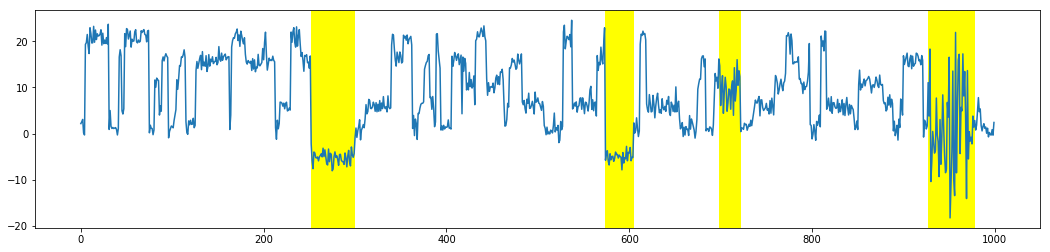

In [78]:
axis = range(X_test[0].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_test[7])

idxs = np.where(Y_test[7] == Y_test[7].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show() 

axis = range(X_test[7].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_test[5])

idxs = np.where(Y_test[5] == Y_test[5].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show()

axis = range(X_test[2].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_test[6])

idxs = np.where(Y_test[6] == Y_test[6].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show()

              precision    recall  f1-score   support

      normal       0.88      0.81      0.84      1067
      anomal       0.80      0.87      0.83       933

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



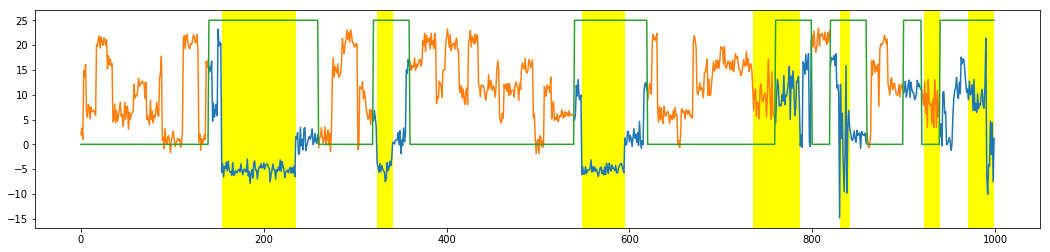

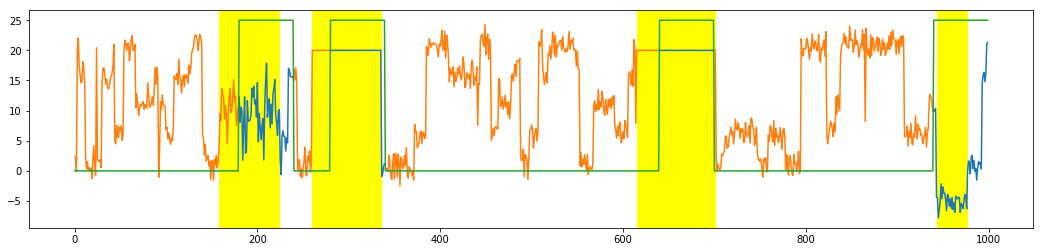

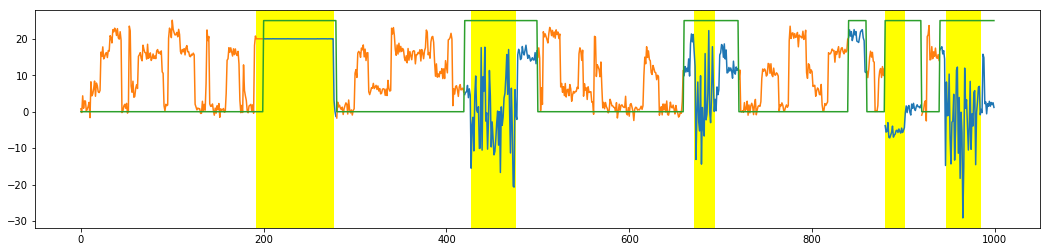

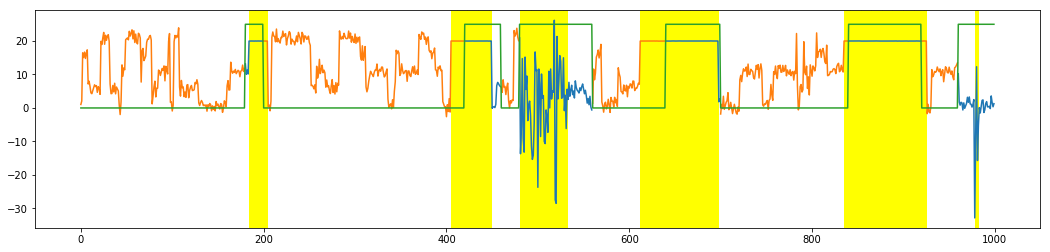

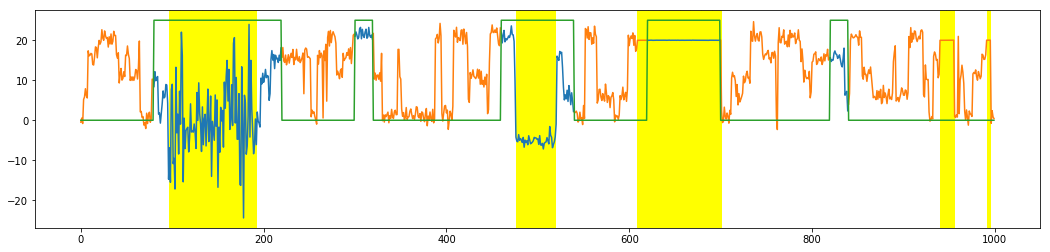

In [109]:
Y_pred = predict(hmm, X_test, Y_test, win_size= 40, eps = 0.21, step = 20)
Y_score, Y_pred_score = score(Y_test, Y_pred, ws = 50)
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)
print_result(X_test, Y_test, Y_pred, N=5)

In [192]:
#ЗАПИСЬ!!!!!!
for_save = (X_test, Y_test)
with open('C:/Users/DNS/NIR/X_Y_test.pkl', 'wb') as dump_out:
      pickle.dump(for_save, dump_out)
with open('C:/Users/DNS/NIR/X_train.pkl', 'wb') as dump_out:
      pickle.dump(get_signals(N=200, T=300, init=big_init), dump_out)        
       


ТЕСТИРОВАНИЕ НА ОРИГИНАЛЬНОЙ МОДЕЛИ!!!!!

In [107]:
_, _, _, pi, A, R, mu, sigma = big_init()
# перевод в формы "pre-softmax" 
pi = np.log(pi)
A = np.log(A)
R = np.log(R)
# декомпозиция sigma с использованием факторизации 
sigma = np.linalg.cholesky(sigma)

hmm_real = HMM(5, 3)
hmm_real.set(pi, A, R, mu, sigma)

ws = 40
eps = 0.21
step = 20
Y_pred_real = predict(hmm_real, X_test, Y_test, win_size= ws, eps = eps, step =step)


              precision    recall  f1-score   support

      normal       0.88      0.85      0.86      1067
      anomal       0.84      0.86      0.85       933

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



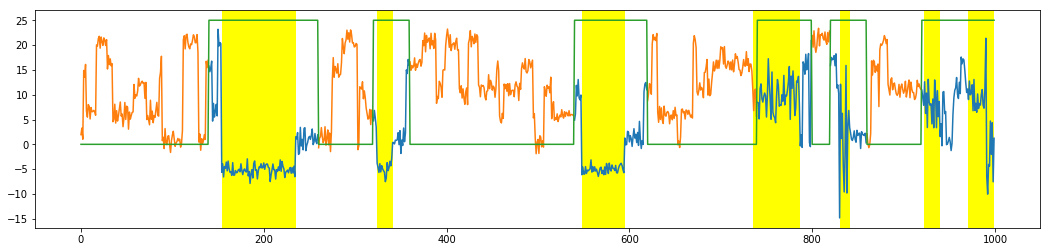

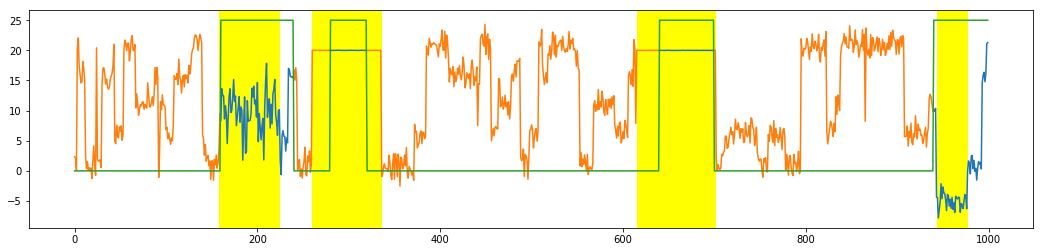

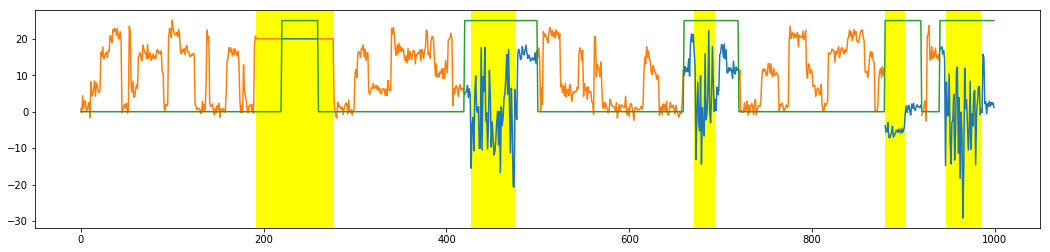

In [108]:
Y_score, Y_pred_score = score(Y_test, Y_pred_real, ws = 50)
report_real = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report_real)
print_result(X_test, Y_test, Y_pred_real, N=3)

In [76]:
with open('C:/Users/DNS/NIR/report_big_init_real__ws'+str(ws)+'eps'+str(eps)+'sens'+str(step)+'.pkl', 'wb') as dump_out:
      pickle.dump(report_real, dump_out)

In [ ]:
fig = plt.figure(figsize=(18, 4))
axis = range(n_step)
#cl = ['red' if x ==1 else 'darkgreen' for x in anomalises]
plt.plot(axis, norm_s0, axis, anom_s0, axis, anomalises[0]*25)
idxs = np.where(Y[0] == Y.max())[0]
plt.axvspan(idxs[0], idxs[-1], color='yellow')
plt.show()
fig = plt.figure(figsize=(18, 4))
axis = range(n_step)
#cl = ['red' if x ==1 else 'darkgreen' for x in anomalises]
plt.plot(axis, norm_s1, axis, anom_s1, axis, anomalises[1]*25)
idxs = np.where(Y[1] == Y.max())[0]
plt.axvspan(idxs[0], idxs[-1], color='yellow')
plt.show()

СРАВНЕНИЕ С ДРУГИМИ АЛГОРИТМАМИ

In [112]:
with open('C:/Users/DNS/NIR/X_train.pkl', 'rb') as dump_out:
      X_train = pickle.load(dump_out) 

In [116]:
X_train = np.concatenate([x.reshape(x.shape[0]) for x in X_train])

In [117]:
X1_test = np.concatenate([x.reshape(x.shape[0]) for x in X_test])

Поиск аномалий в одномерных временных рядов

    Параметры инициализации:
        Окно (INT): ширина окна анализа
        альфа (двойной, от 0 до 1): критическое р-значение для описательной статистики
        Порог (двойной, от 0 до 1): критическое значение для сигнализации аномалия на сглаженных серии

    Возвращает:
        NumPy массив той же длины, что входные серии, содержащей аномалии этикетки - 0 (OK) или 1 (аномалия)
        
        
        тестирование p_value (Критерий стьюдента и Хи квадрат пирсона

In [123]:
import ECDF
model=ECDF.DefaultDetector(window=20, alpha=0.01, threshold=0.1)
model.fit(X_train)
Y1_pred=model.detect(X1_test)


In [130]:
Y1_pred =Y1_pred.reshape(len(Y_test),Y_test[0].shape[0])#*1
#c[40:][5]

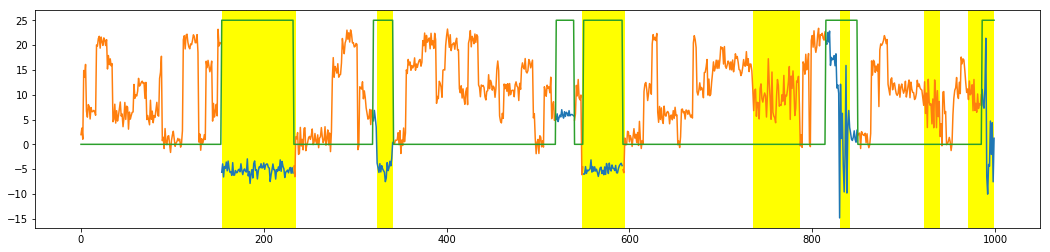

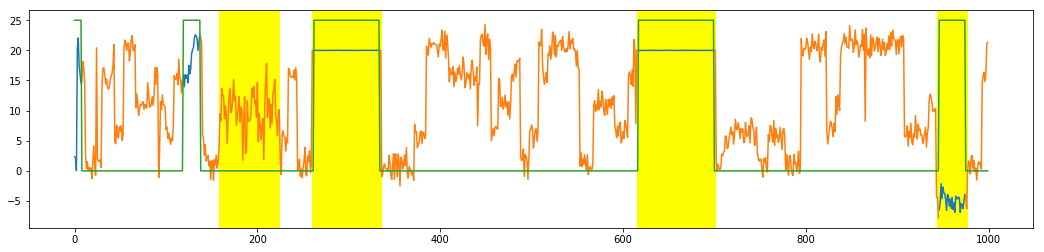

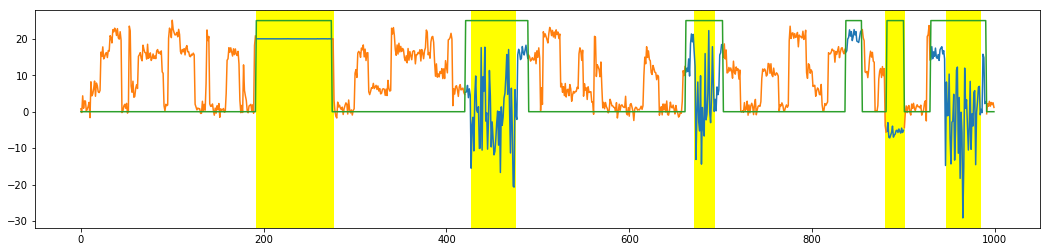

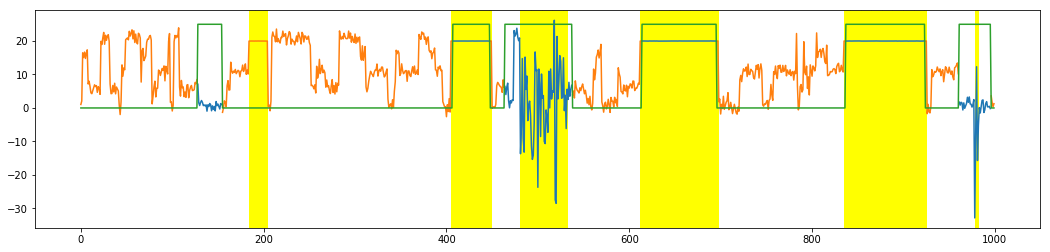

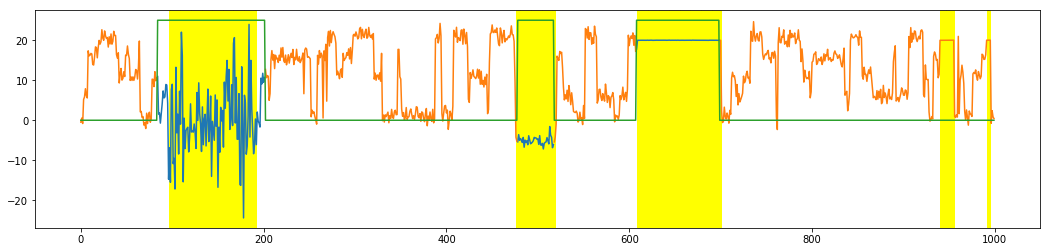

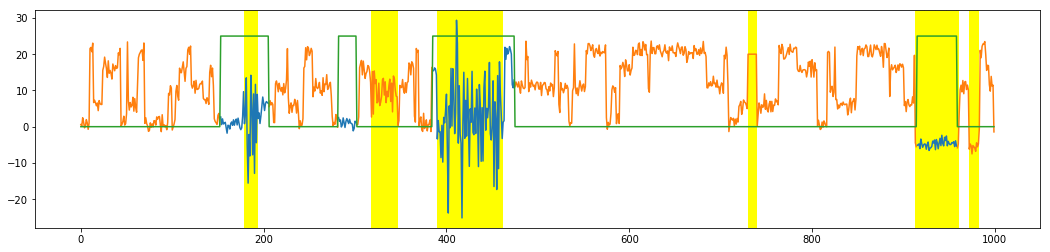

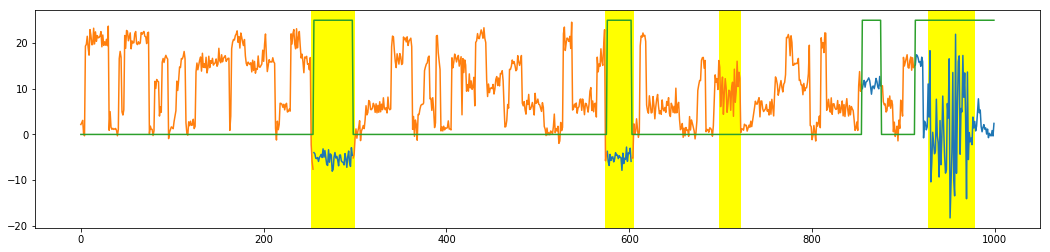

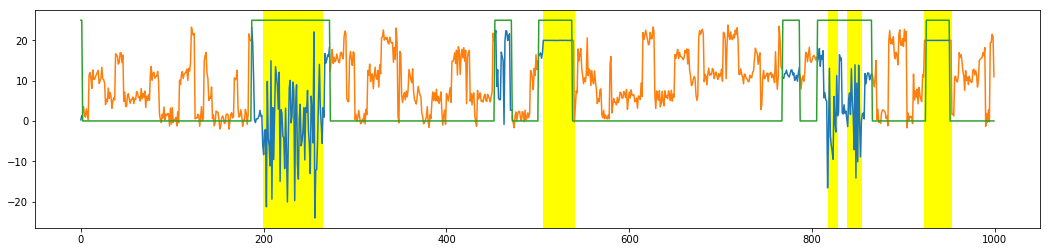

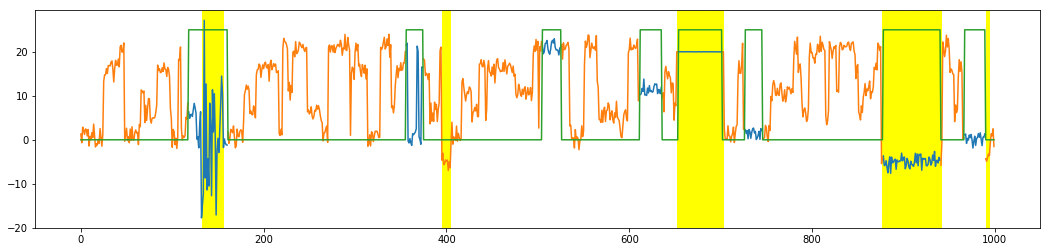

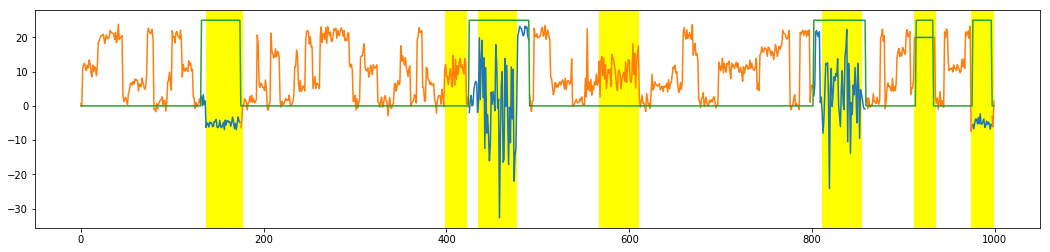

In [131]:
print_result(X_test, Y_test,Y1_pred, N=10)

In [132]:
Y_score, Y1_pred_score = score(Y_test, Y1_pred, ws = 50)   

In [134]:
report_ECDF = classification_report(np.concatenate(Y_test), np.concatenate(Y1_pred), target_names=['normal', 'anomal'])
print(report_ECDF)

              precision    recall  f1-score   support

      normal       0.91      0.93      0.92     75522
      anomal       0.77      0.71      0.74     24478

    accuracy                           0.88    100000
   macro avg       0.84      0.82      0.83    100000
weighted avg       0.87      0.88      0.88    100000



In [140]:
report_ECDF = classification_report(np.concatenate(Y_score), np.concatenate(Y1_pred_score), target_names=['normal', 'anomal'])
print(report_ECDF)

              precision    recall  f1-score   support

      normal       0.73      0.81      0.77      1067
      anomal       0.76      0.65      0.70       933

    accuracy                           0.74      2000
   macro avg       0.74      0.73      0.74      2000
weighted avg       0.74      0.74      0.74      2000

